# ECSE415 - Intro to Computer Vision
## Assignment 2
### Alexander Harris - 260688155

## Image Classification
## 1. Coding Questions:

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Import, resize and classify data
dataset = os.listdir('./dataset')
size = (128, 128)
ford_train = []
vw_train = []
ford_test = []
vw_test = []

for file in dataset:
    img = cv2.imread('./dataset/' + file)
    img = cv2.resize(img, size)
    if file.startswith('volks_train'):
        vw_train.append(img)
    elif file.startswith('volks_test'):
        vw_test.append(img)
    elif file.startswith('ford_train'):
        ford_train.append(img)
    elif file.startswith('ford_test'):
        ford_test.append(img)

In [2]:
def HoG_features(data, cell_size, block_size, nbins):
    hog_features = []
    for img in data:
        img_h, img_w = img.shape[:2]
        cell_h, cell_w = cell_size
        block_h, block_w = block_size
        
        # Compute HoG features
        hog = cv2.HOGDescriptor(_winSize=(img_w // cell_w * cell_w, img_h // cell_h * cell_h),
                               _blockSize=(block_w * cell_w, block_h * cell_h),
                               _blockStride=(cell_w, cell_h),
                               _cellSize=(cell_w, cell_h),
                               _nbins=nbins)
        
        cells = (img_h // cell_h, img_w // cell_w)
        hog_f = hog.compute(img).reshape(cells[1] - block_w + 1, cells[0] - block_h + 1, block_h, block_w, nbins).transpose(1, 0, 2, 3, 4)
        
        # Compute blocknorm
        grad = np.zeros((cells[0], cells[1], nbins)).astype(np.float)
        num_cells = np.zeros((cells[0], cells[1], 1)).astype(np.float)
        
        for x_offset in range(block_h):
            for y_offset in range(block_w):
                grad[y_offset:cells[0] - block_h + y_offset + 1, x_offset:cells[1] - block_w + x_offset + 1] += hog_f[:, :, y_offset, x_offset, :]
                num_cells[y_offset:cells[0] - block_h + y_offset + 1, x_offset:cells[1] - block_w + x_offset + 1] += 1
        
        grad /= num_cells
        hog_features.append(grad)
        
    return hog_features    

In [13]:
# Compute features for VW and Ford datasets
vw_features = HoG_features(vw_train, (4,4), (4,4), 8)
ford_features = HoG_features(ford_train, (4,4), (4,4), 8)

In [14]:
# Train classifier
features = np.array(vw_features + ford_features)
features = features.reshape(features.shape[0], -1)

labels = ['volkswagen'] * len(vw_train) + ['ford'] * len(ford_train)

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(features, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

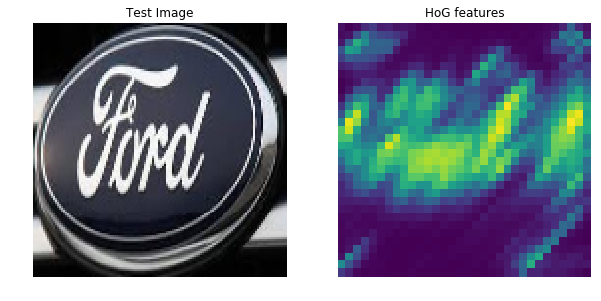

Class:  ford


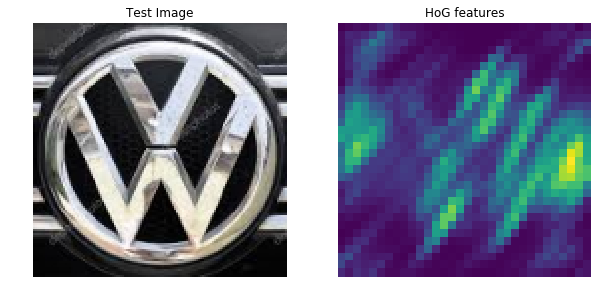

Class:  volkswagen


In [17]:
# Test images
test_images = ford_test + vw_test
test_features = np.array(HoG_features(test_images, (4,4), (4,4), 8))
predicted_class = classifier.predict(test_features.reshape(len(test_images), -1))

for img, features, c in zip(test_images, test_features, predicted_class):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Test Image'), plt.axis('off')
    plt.subplot(122)
    plt.pcolor(features[:, :, 0])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('HoG features'), plt.axis('off')
    plt.show()
    print('Class: ', c)

## 2. Reasoning Questions
### 2.1 Will HoG work if images undergo random rotation
No, since HoG relies on the orientation of the image. We can use the techniques seen in Image Stitching to compute the keypoints using SIFT/SURF, find the matching ones and use those to compute homography, which we can then use to warp the images so that they all have the same orientation.

### 2.2 Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are sufficient in order to correctly classify the images into three categories?
We would only need two different directions of the gradient since there are only two possible directions. Therefore, a gradient in X and one in Y.